<h1>Assignment 2 Group 10 (Renk, Leon and Payal) </h1>

In [1]:
import tarfile
import pandas as pd
import os

In [2]:
def count_png_files_in_folder(folder_path):
    png_count = 0
    
    for root, dirs, files in os.walk(folder_path):
        png_count += sum(1 for file in files if file.endswith('.png'))
    return png_count

count_png_files_in_folder("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1")


7909

Import data to df with Benign/Malignant IDs and choosing magnification

In [3]:
def extract_image_labels(folder_path):
    file_paths = []
    labels = []

    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == '100':
                    labels.append(label)
                    file_paths.append(file_path)

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df


In [4]:
image_labels_df = extract_image_labels("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1")

In [5]:
image_labels_df.head(5)

,FilePath,Label
0,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
1,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
2,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
3,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M
4,/Users/renkasik/Desktop/Intro To Focus Areas/d...,M


<h3> Split data into train. test and validation sets </h3>

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1456, 2)
The shape of test data (312, 2)
The shape of validation data (313, 2)


In [8]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

<h3> Distribution of train, test and validation Datasets </h3>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

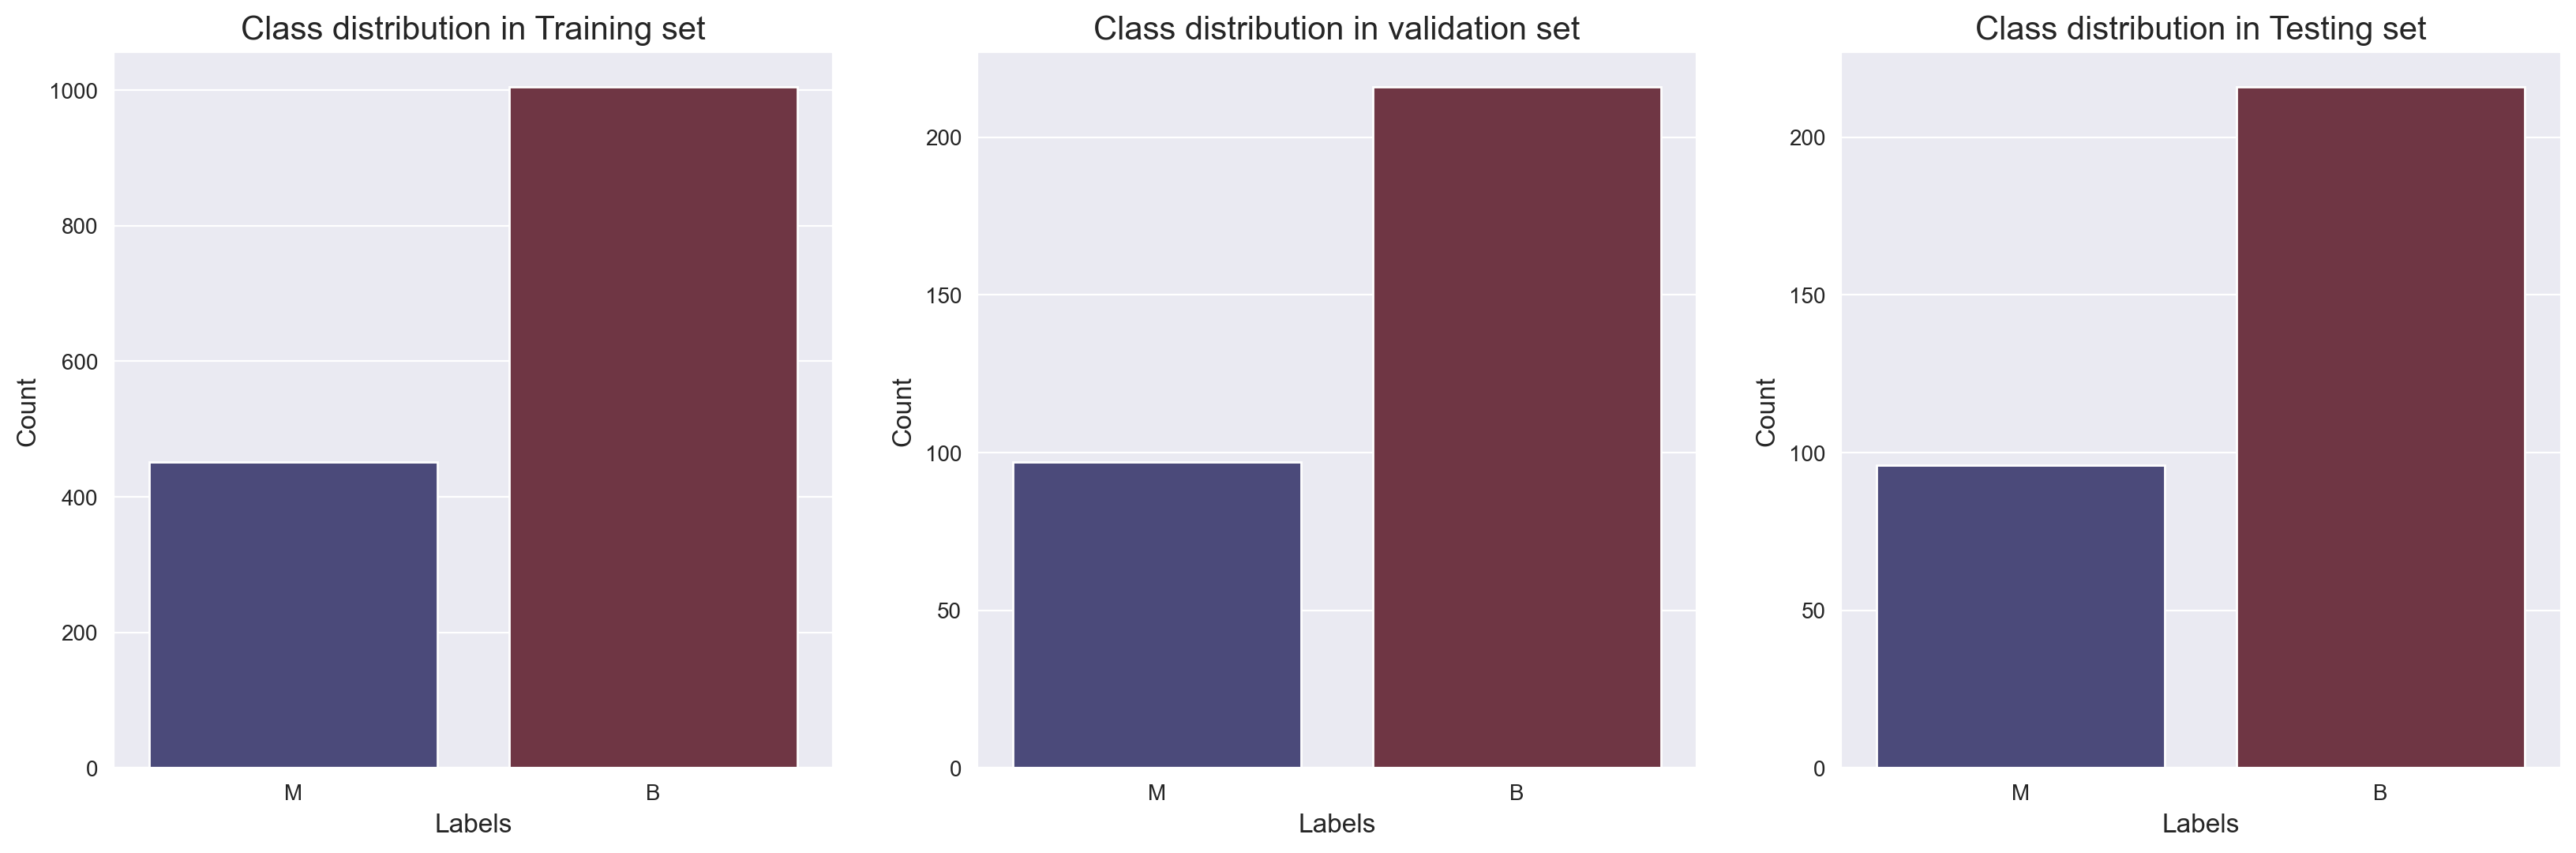

In [10]:
labels = ['M','B']

#count unique label appearances
label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

# DataFrames with 1 column for count of labels, label names in index
uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index, y='Count1', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index, y='Count2', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index, y='Count3', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

<h2> Deep Learning based Classifiers </h2>

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall

<h3> CNN </h3>

In [12]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [13]:
base_dir = "/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1"

In [14]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [15]:
i = 0
for filepath in train_filepaths:
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")

In [16]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = create_dataset(train_filepaths, train_labels).shuffle(buffer_size=len(train_filepaths)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

2024-11-11 12:14:21.560545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [19]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 5s 30ms/step - loss: 0.6178 - accuracy: 0.6848 - precision: 0.6917 - recall: 0.9801 - val_loss: 0.5807 - val_accuracy: 0.6901 - val_precision: 0.6901 - val_recall: 1.0000
Epoch 2/10
46/46 [==============================] - 3s 25ms/step - loss: 0.5391 - accuracy: 0.7060 - precision: 0.7207 - recall: 0.9373 - val_loss: 0.7227 - val_accuracy: 0.6901 - val_precision: 0.6901 - val_recall: 1.0000
Epoch 3/10
46/46 [==============================] - 3s 23ms/step - loss: 0.5075 - accuracy: 0.7768 - precision: 0.7911 - recall: 0.9194 - val_loss: 0.5181 - val_accuracy: 0.7188 - val_precision: 0.7105 - val_recall: 1.0000
Epoch 4/10
46/46 [==============================] - 3s 23ms/step - loss: 0.5230 - accuracy: 0.7562 - precision: 0.7629 - recall: 0.9383 - val_loss: 0.4871 - val_accuracy: 0.7891 - val_precision: 0.7717 - val_recall: 0.9861
Epoch 5/10
46/46 [==============================] - 3s 23ms/step - loss: 0.4703 - accuracy: 0.7953 - precisi

In [20]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

10/10 [==============================] - 1s 52ms/step - loss: 0.4536 - accuracy: 0.7885 - precision: 0.7717 - recall: 0.9861
Loss: 0.45361587405204773
Accuracy: 0.7884615659713745
Precision: 0.77173912525177
Recall(Sensitivity): 0.9861111044883728


<h3>Fully connected NN with one hidden layer </h3>

In [21]:
model_2 = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),  # fully connected -> flatten from 2D to 1D
    layers.Dense(64, activation='relu'),  # hidden layer -> learning features from the input data
    layers.Dense(1, activation='sigmoid') 
])

In [22]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [23]:
history_2 = model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 4s 18ms/step - loss: 0.7610 - accuracy: 0.6422 - precision_1: 0.6845 - recall_1: 0.8935 - val_loss: 0.6112 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 2/10
46/46 [==============================] - 3s 13ms/step - loss: 0.6096 - accuracy: 0.6902 - precision_1: 0.6902 - recall_1: 1.0000 - val_loss: 0.5995 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 3/10
46/46 [==============================] - 3s 13ms/step - loss: 0.5949 - accuracy: 0.6902 - precision_1: 0.6902 - recall_1: 1.0000 - val_loss: 0.5843 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 4/10
46/46 [==============================] - 3s 13ms/step - loss: 0.5772 - accuracy: 0.6902 - precision_1: 0.6902 - recall_1: 1.0000 - val_loss: 0.5592 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 5/10
46/46 [==============================] - 3s 13ms/step - loss: 0.5

In [24]:
results_2 = model_2.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_2)):
    print(metrics[i] + ': ' + str(results_2[i]))

10/10 [==============================] - 1s 48ms/step - loss: 0.4697 - accuracy: 0.8237 - precision_1: 0.8108 - recall_1: 0.9722
Loss: 0.46973899006843567
Accuracy: 0.8237179517745972
Precision: 0.8108108043670654
Recall(Sensitivity): 0.9722222089767456


<h3>ResNet-50 </h3>

In [25]:
from tensorflow.keras.applications import ResNet50

In [26]:
IMG_SIZE_resnet = (224, 224) #ResNet50 input size requirement

def load_and_preprocess_image_resnet(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE_resnet)
    image = tf.keras.applications.resnet50.preprocess_input(image) #ResNet preprocessing
    return image

In [27]:
def create_dataset_resnet(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels for ResNet
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [28]:
# Shuffle, batch, and prefetch the datasets
train_ds_resnet = create_dataset_resnet(train_filepaths, train_labels).shuffle(buffer_size=len(train_filepaths)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_resnet = create_dataset_resnet(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds_resnet = create_dataset_resnet(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #without the top classification layer to add custom classification layers later
base_model.trainable = False  #freeze base model to avoid fine tuning

In [30]:
model_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #reduce output to single vector
    layers.Dense(1, activation='sigmoid')  
])

In [31]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [32]:
history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 96s 2s/step - loss: 0.5027 - accuracy: 0.7548 - precision_2: 0.7817 - recall_2: 0.8945 - val_loss: 0.4176 - val_accuracy: 0.7955 - val_precision_2: 0.8248 - val_recall_2: 0.8935
Epoch 2/10
46/46 [==============================] - 93s 2s/step - loss: 0.3310 - accuracy: 0.8599 - precision_2: 0.8671 - recall_2: 0.9413 - val_loss: 0.3482 - val_accuracy: 0.8658 - val_precision_2: 0.9104 - val_recall_2: 0.8935
Epoch 3/10
46/46 [==============================] - 93s 2s/step - loss: 0.2746 - accuracy: 0.8956 - precision_2: 0.9058 - recall_2: 0.9473 - val_loss: 0.3061 - val_accuracy: 0.8946 - val_precision_2: 0.9217 - val_recall_2: 0.9259
Epoch 4/10
46/46 [==============================] - 93s 2s/step - loss: 0.2410 - accuracy: 0.9100 - precision_2: 0.9123 - recall_2: 0.9622 - val_loss: 0.2827 - val_accuracy: 0.8978 - val_precision_2: 0.9299 - val_recall_2: 0.9213
Epoch 5/10
46/46 [==============================] - 93s 2s/step - loss: 0.2135 -

In [33]:
#fine tuning
base_model.trainable = True
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  #lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=5)

Epoch 1/5


46/46 [==============================] - 338s 7s/step - loss: 0.6844 - accuracy: 0.7102 - precision_3: 0.9802 - recall_3: 0.5920 - val_loss: 0.3692 - val_accuracy: 0.8275 - val_precision_3: 0.8022 - val_recall_3: 0.9954
Epoch 2/5
46/46 [==============================] - 334s 7s/step - loss: 0.1852 - accuracy: 0.9286 - precision_3: 0.9829 - recall_3: 0.9124 - val_loss: 0.3451 - val_accuracy: 0.8435 - val_precision_3: 0.8199 - val_recall_3: 0.9907
Epoch 3/5
46/46 [==============================] - 340s 7s/step - loss: 0.0777 - accuracy: 0.9883 - precision_3: 0.9960 - recall_3: 0.9871 - val_loss: 0.2702 - val_accuracy: 0.8882 - val_precision_3: 0.8694 - val_recall_3: 0.9861
Epoch 4/5
46/46 [==============================] - 336s 7s/step - loss: 0.0440 - accuracy: 0.9959 - precision_3: 0.9960 - recall_3: 0.9980 - val_loss: 0.2107 - val_accuracy: 0.9105 - val_precision_3: 0.8983 - val_recall_3: 0.9815
Epoch 5/5
46/46 [==============================] - 338s 7s/step - loss: 0.0306 - accuracy:

In [34]:
results_3 = model_3.evaluate(test_ds_resnet)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_3)):
    print(metrics[i] + ': ' + str(results_3[i]))

10/10 [==============================] - 17s 2s/step - loss: 0.1745 - accuracy: 0.9263 - precision_3: 0.9177 - recall_3: 0.9815
Loss: 0.17446044087409973
Accuracy: 0.9262820482254028
Precision: 0.9177489280700684
Recall(Sensitivity): 0.9814814925193787


<h3>Plots</h3>

<h3>Metric Comparison</h3>

In [35]:
results = np.array(results)
results_2 = np.array(results_2)
results_3 = np.array(results_3)
results_df = pd.DataFrame({'CNN': results, 'Shallow NN': results_2, 'ResNet50': results_3})

results_df = results_df.T

results_df.columns = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
results_df

,Loss,Accuracy,Precision,Recall(Sensitivity)
CNN,0.453616,0.788462,0.771739,0.986111
Shallow NN,0.469739,0.823718,0.810811,0.972222
ResNet50,0.174460,0.926282,0.917749,0.981481


<Figure size 1440x1080 with 0 Axes>

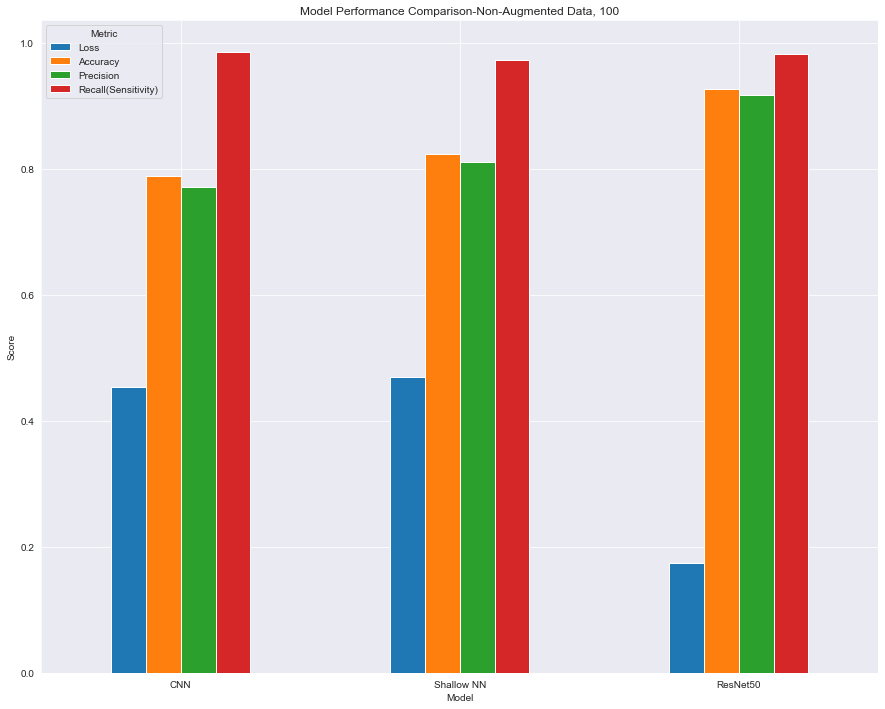

In [36]:
plt.figure(figsize=(20, 15))

results_df.plot(kind='bar', rot=0, figsize=(15,12))
plt.title('Model Performance Comparison-Non-Augmented Data, 100')
plt.ylabel('Score')
plt.xlabel('Model')  

# Show the plot
plt.legend(title='Metric')
plt.show()

<h3>ROC Curves</h3>

In [37]:
from sklearn.metrics import roc_curve, auc

In [38]:
X_test_images = np.array([load_and_preprocess_image(fp) for fp in X_test['FilePath']])
X_test_images_resnet = np.array([load_and_preprocess_image_resnet(fp) for fp in X_test['FilePath']])

probabilities_CNN = model.predict(X_test_images)
probabilities_ShallowNN = model_2.predict(X_test_images)
probabilities_ResNet50 = model_3.predict(X_test_images_resnet)


10/10 [==============================] - 17s 2s/step


In [39]:
fpr_CNN, tpr_CNN, _ = roc_curve(test_labels, probabilities_CNN)
fpr_ShallowNN, tpr_ShallowNN, _ = roc_curve(test_labels, probabilities_ShallowNN)
fpr_ResNet50, tpr_ResNet50, _ = roc_curve(test_labels, probabilities_ResNet50)

auc_CNN = auc(fpr_CNN, tpr_CNN)
auc_ShallowNN = auc(fpr_ShallowNN, tpr_ShallowNN)
auc_ResNet50 = auc(fpr_ResNet50, tpr_ResNet50)

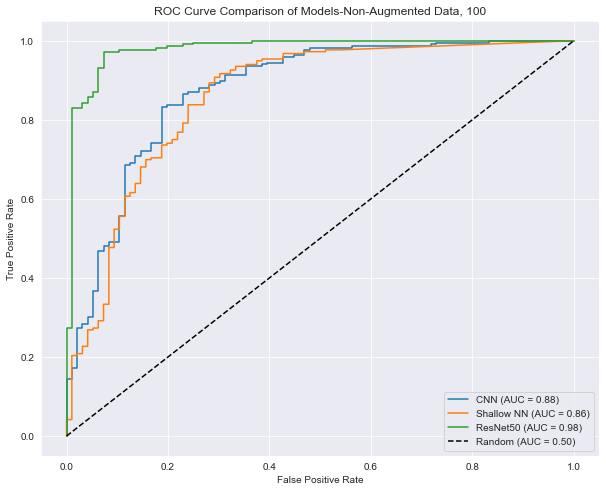

In [40]:
plt.figure(figsize=(10, 8))


plt.plot(fpr_CNN, tpr_CNN, label=f'CNN (AUC = {auc_CNN:.2f})')
plt.plot(fpr_ShallowNN, tpr_ShallowNN, label=f'Shallow NN (AUC = {auc_ShallowNN:.2f})')
plt.plot(fpr_ResNet50, tpr_ResNet50, label=f'ResNet50 (AUC = {auc_ResNet50:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models-Non-Augmented Data, 100')
plt.legend(loc='lower right')
plt.show()

<h3>Confusion Matrix</h3>

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
#probabilities to binary predictions
pred_CNN = (probabilities_CNN > 0.5).astype(int)
pred_ShallowNN = (probabilities_ShallowNN > 0.5).astype(int)
pred_ResNet50 = (probabilities_ResNet50 > 0.5).astype(int)

In [43]:
cm_CNN = confusion_matrix(test_labels, pred_CNN)
cm_ShallowNN = confusion_matrix(test_labels, pred_ShallowNN)
cm_ResNet50 = confusion_matrix(test_labels, pred_ResNet50)

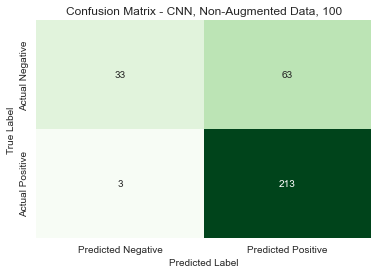

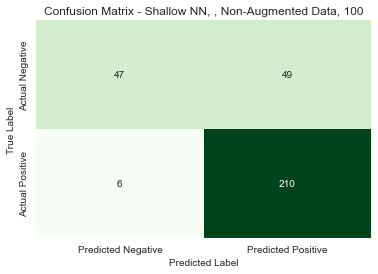

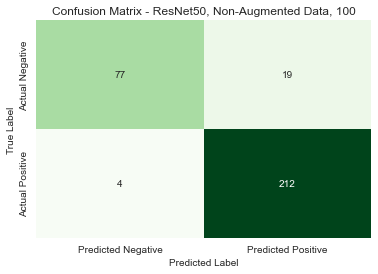

In [44]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_CNN, "Confusion Matrix - CNN, Non-Augmented Data, 100")
plot_confusion_matrix(cm_ShallowNN, "Confusion Matrix - Shallow NN, , Non-Augmented Data, 100")
plot_confusion_matrix(cm_ResNet50, "Confusion Matrix - ResNet50, Non-Augmented Data, 100")

<h3>Learning Curves</h3>

<h3>Training/Validation Accuracy </h3>

In [45]:
def plot_accuracy(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

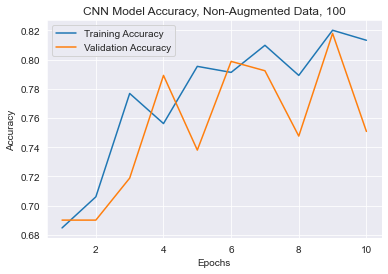

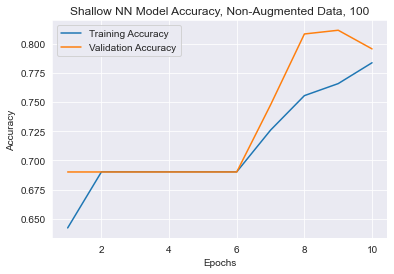

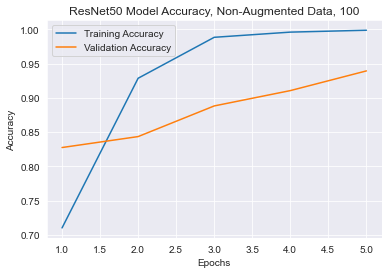

In [46]:
plot_accuracy(history, 'CNN Model Accuracy, Non-Augmented Data, 100')
plot_accuracy(history_2, 'Shallow NN Model Accuracy, Non-Augmented Data, 100')
plot_accuracy(history_3, 'ResNet50 Model Accuracy, Non-Augmented Data, 100')

<h3>Training/Validation Loss </h3>

In [47]:
def plot_loss(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

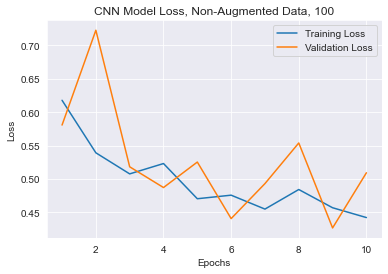

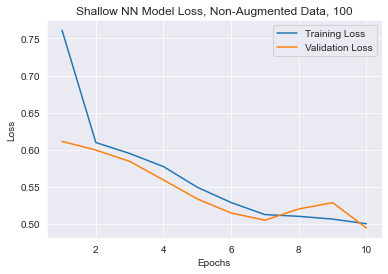

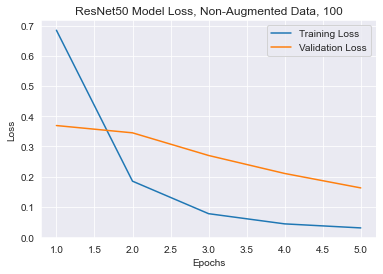

In [48]:
plot_loss(history, 'CNN Model Loss, Non-Augmented Data, 100')
plot_loss(history_2, 'Shallow NN Model Loss, Non-Augmented Data, 100')
plot_loss(history_3, 'ResNet50 Model Loss, Non-Augmented Data, 100')